# Prediction of Active Enhancers with FFNN

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from typing import List
from tqdm.auto import tqdm
from keras_tqdm import TQDMNotebookCallback as ktqdm
from multiprocessing import cpu_count
import compress_json
import os
from barplots import barplots

Using TensorFlow backend.


## Models

In [2]:
models = []
kwargs = []

### Decision Trees

In [3]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(
    criterion="gini",
    max_depth=50,
    random_state=42,
    class_weight="balanced"
)

models.append(decision_tree)
kwargs.append({})

### Random forests

In [4]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(
    n_estimators=500,
    criterion="gini",
    max_depth=30,
    random_state=42,
    class_weight="balanced",
    n_jobs=cpu_count()
)

models.append(random_forest)
kwargs.append({})

### Perceptron

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping


perceptron = Sequential([
    Input(shape=(104, )),
    Dense(1, activation="sigmoid")
], "Perceptron")

perceptron.compile(
    optimizer="nadam",
    loss="binary_crossentropy"
)

models.append(perceptron)
kwargs.append(dict(
    epochs=1000,
    batch_size=1024,
    validation_split=0.1,
    shuffle=True,
    verbose=False,
    callbacks=[
        EarlyStopping(monitor="val_loss", mode="min", patience=50),
        ktqdm(leave_outer=False)
    ]
))

### Multi-Layer Perceptron (MLP)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

mlp = Sequential([
    Input(shape=(104, )),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
], "MLP")

mlp.compile(
    optimizer="nadam",
    loss="binary_crossentropy"
)

models.append(mlp)
kwargs.append(dict(
    epochs=1000,
    batch_size=1024,
    validation_split=0.1,
    shuffle=True,
    verbose=False,
    callbacks=[
        EarlyStopping(monitor="val_loss", mode="min", patience=50),
        ktqdm(leave_outer=False)
    ]
))

### Feed-Forward Neural Network (FFNN)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout


ffnn = Sequential([
    Input(shape=(104, )),
    Dense(256, activation="relu"),
    Dense(128),
    BatchNormalization(),
    Activation("relu"),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(1, activation="sigmoid")
], "FFNN")

ffnn.compile(
    optimizer="nadam",
    loss="binary_crossentropy"
)

models.append(ffnn)
kwargs.append(dict(
    epochs=1000,
    batch_size=1024,
    validation_split=0.1,
    shuffle=True,
    verbose=False,
    callbacks=[
        EarlyStopping(monitor="val_loss", mode="min", patience=50),
        ktqdm(leave_outer=False)
    ]
))

## Meta-models

### Grid search

### Random search

### Tree of Parzen

### Bayesian optimization with gaussian processes

### Distributed Bayesian optimization

## The experimental setup

## Retrieving the data

In [8]:
from epigenomic_dataset import load_epigenomes
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

# The considered window size
window_size = 200

# Retrieving the input data
X, y = load_epigenomes(
    cell_line = "GM12878",
    dataset = "fantom",
    regions = "enhancers",
    window_size = window_size
)
X = X.droplevel(1, axis=1)
y = y.values.ravel()

# Imputation of NaN Values
X[X.columns] = KNNImputer(n_neighbors=X.shape[0]//10).fit_transform(X)

# Robust normalization of the values
X[X.columns] = RobustScaler().fit_transform(X)

X = X.values

## Preparing the holdouts

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

splits = 50
holdouts = StratifiedShuffleSplit(n_splits=splits, test_size=0.2, random_state=42)

## Training the models

In [10]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, average_precision_score
from sanitize_ml_labels import sanitize_ml_labels

def report(y_true:np.ndarray, y_pred:np.ndarray)->np.ndarray:
    integer_metrics = accuracy_score, balanced_accuracy_score
    float_metrics = roc_auc_score, average_precision_score
    results1 = {
        sanitize_ml_labels(metric.__name__): metric(y_true, np.round(y_pred))
        for metric in integer_metrics
    }
    results2 = {
        sanitize_ml_labels(metric.__name__): metric(y_true, y_pred)
        for metric in float_metrics
    }
    return {
        **results1,
        **results2
    }

In [11]:
def precomputed(results, model:str, holdout:int)->bool:
    df = pd.DataFrame(results)
    if df.empty:
        return False
    return (
        (df.model == model) &
        (df.holdout == holdout)
    ).any()

In [12]:
if os.path.exists("results.json"):
    results = compress_json.local_load("results.json")
else:
    results = []
    
for i, (train, test) in tqdm(enumerate(holdouts.split(X, y)), total=splits, desc="Computing holdouts", dynamic_ncols=True):
    for model, params in tqdm(zip(models, kwargs), total=len(models), desc="Training models", leave=False, dynamic_ncols=True):
        model_name = (
            model.__class__.__name__
            if model.__class__.__name__ != "Sequential"
            else model.name
        )
        if precomputed(results, model_name, i):
            continue
        model.fit(X[train], y[train], **params)
        results.append({
            "model":model_name,
            "run_type":"train",
            "holdout":i,
            **report(y[train], model.predict(X[train]))
        })
        results.append({
            "model":model_name,
            "run_type":"test",
            "holdout":i,
            **report(y[test], model.predict(X[test]))
        })
        compress_json.local_dump(results, "results.json")

## Collecting the results

In [13]:
df = pd.DataFrame(results)
df = df.drop(columns=["holdout"])

In [14]:
barplots(
    df,
    groupby=["model", "run_type"],
    show_legend=False,
    height=5,
    orientation="horizontal"
)

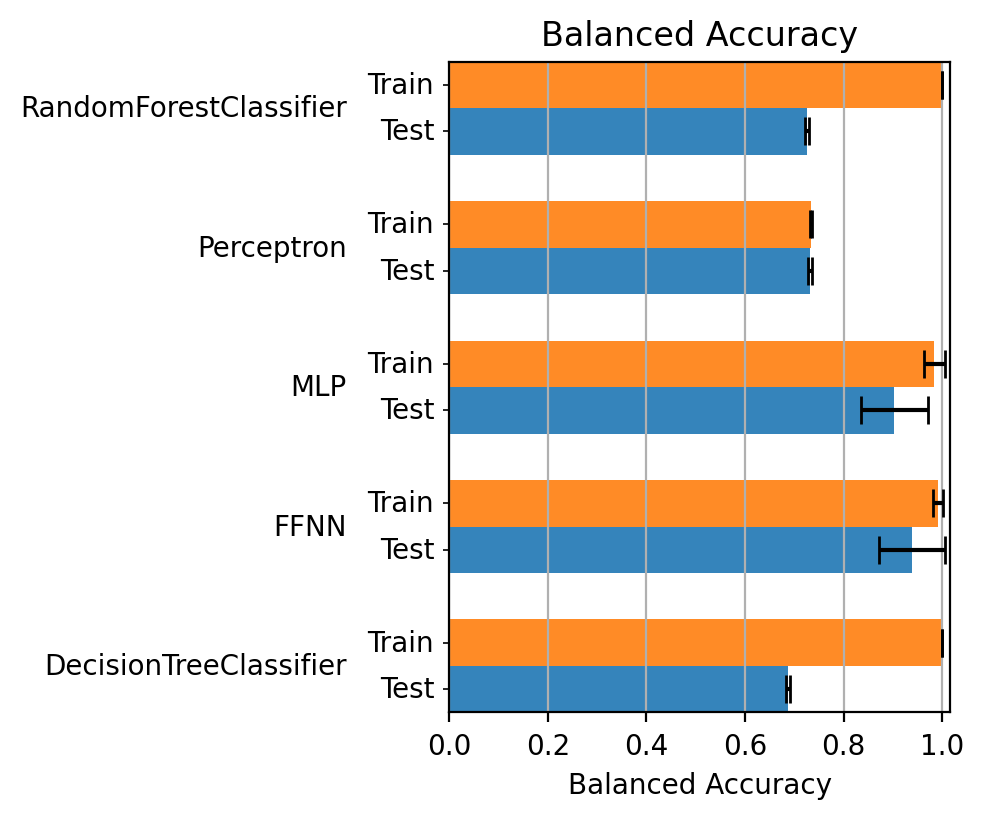

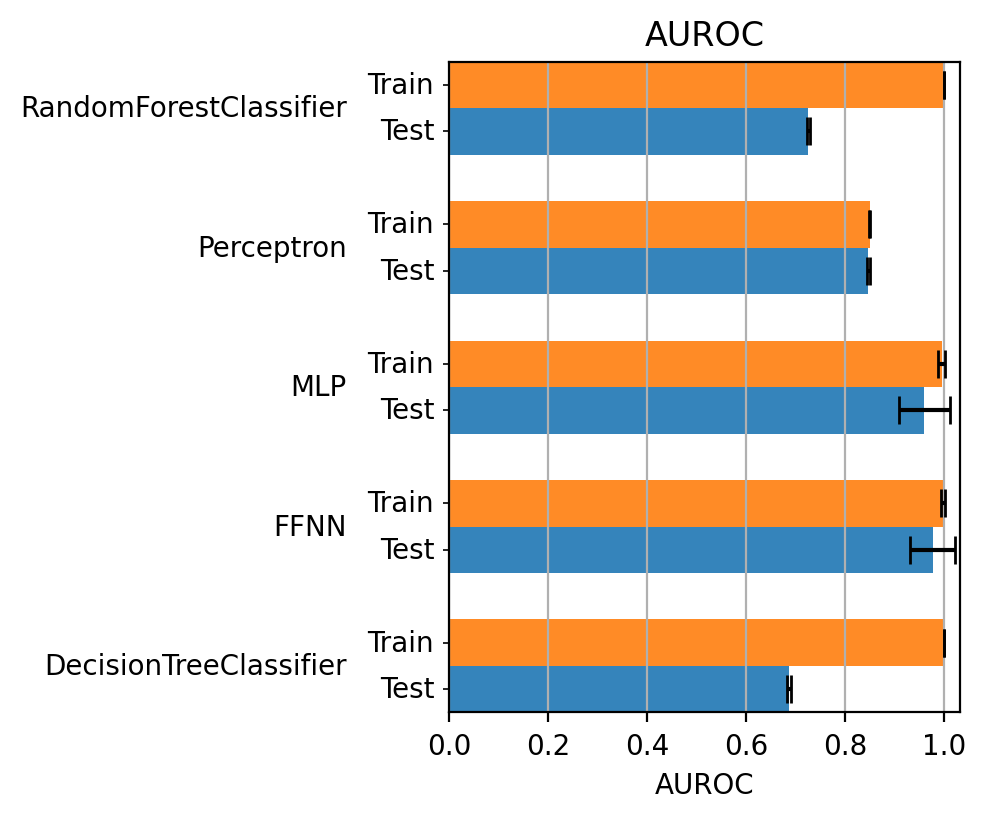

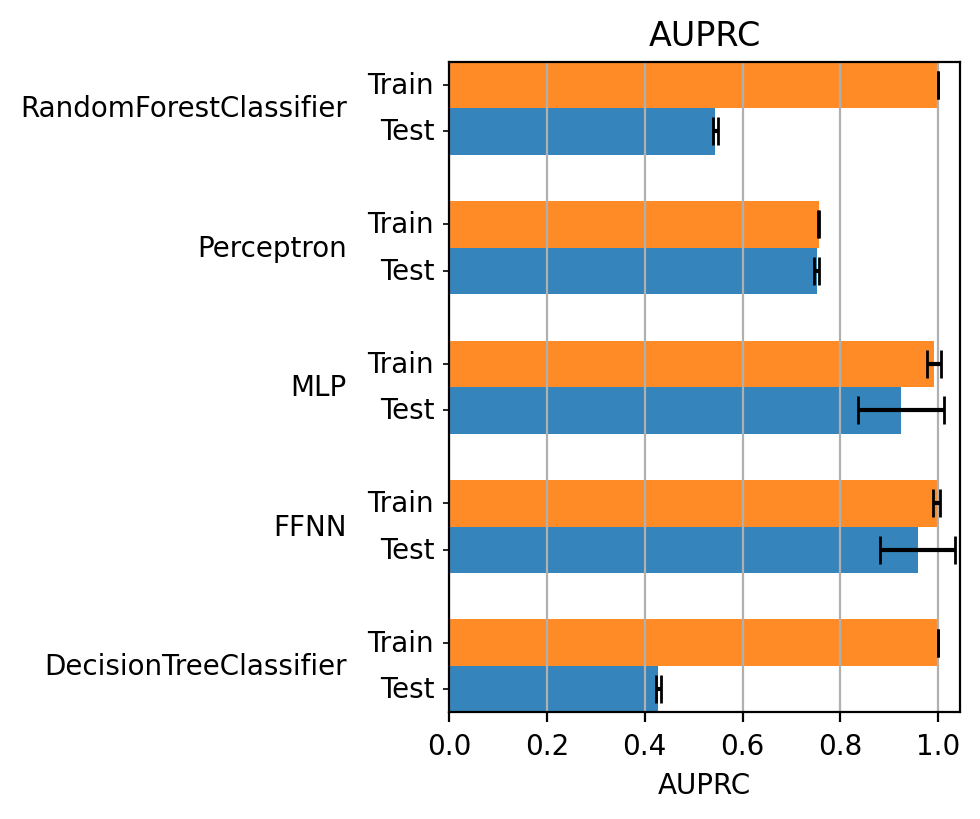

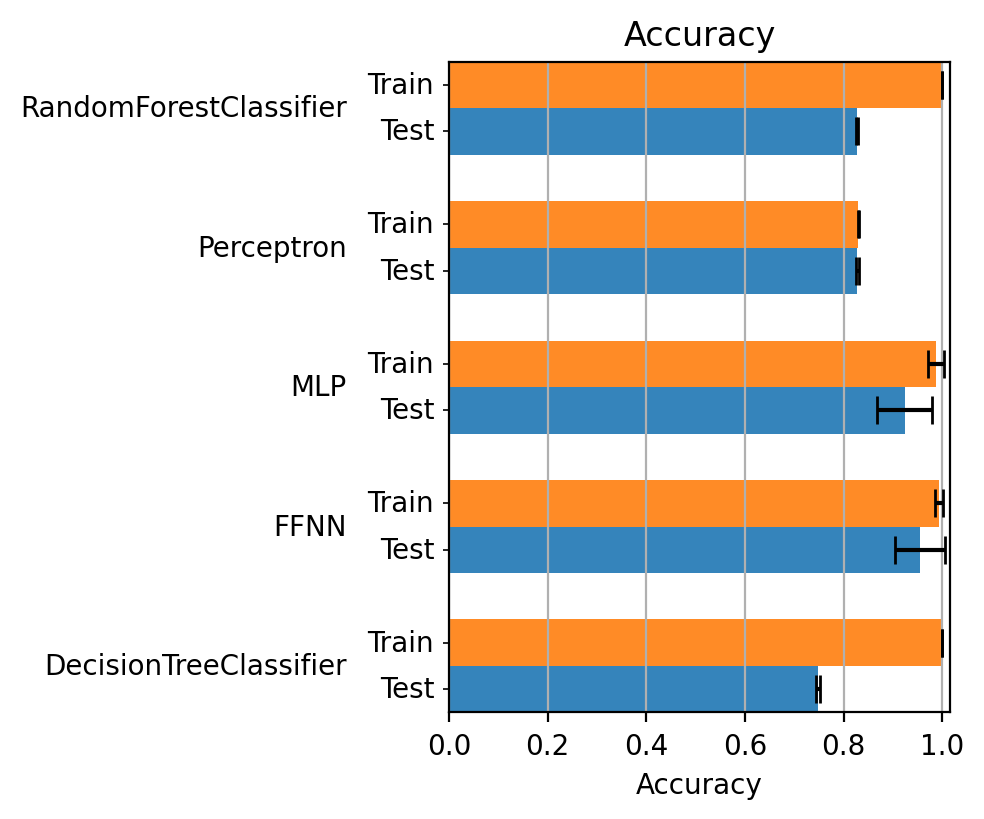

In [15]:
from PIL import Image
from glob import glob

for x in glob("barplots/*.png"):
    display(Image.open(x))

## Conclusions